In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [13]:
df = pd.read_csv(r"C:\Users\abhay.bhandari\Jupyter files\Book.csv")
df.head()

,Invoice Date,Invoice Amount
0,12/17/2019,"$11,424.60"
1,12/18/2019,"$15,120.35"
2,12/24/2019,"$14,060.80"
3,12/27/2019,"$7,749.65"
4,12/30/2019,$507.00


In [14]:
df = df.set_index('Invoice Date')
df.index = pd.to_datetime(df.index)

In [15]:
df['Invoice Amount'] = df['Invoice Amount'].str.replace('$', '').str.replace(',', '').astype(float)
data_10d = df['Invoice Amount'].resample('10D').sum()

C:\Users\abhay.bhandari\AppData\Local\Temp\ipykernel_14120\628915982.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Invoice Amount'] = df['Invoice Amount'].str.replace('$', '').str.replace(',', '').astype(float)


In [56]:
data_10d = data_10d.fillna(0)
df_10d = pd.DataFrame(data_10d)
df_10d = df_10d.reset_index()

In [57]:
df_10d.set_index('Invoice Date', inplace=True)
df_10d.index = pd.to_datetime(df_10d.index)
df_10d.head()

,Invoice Amount
Invoice Date,
2019-12-17,40605.75
2019-12-27,22371.40
2020-01-06,47846.13
2020-01-16,30738.75
2020-01-26,45360.15


In [42]:
# Convert 'Invoice Amount' to a numerical data type
df_10d['Invoice Amount'] = pd.to_numeric(df_10d['Invoice Amount'], errors='coerce')

# Check for missing or non-numeric values
missing_values = df_10d['Invoice Amount'].isna().sum()
if missing_values > 0:
    print(f"Warning: {missing_values} rows contain non-numeric values in the 'Invoice Amount' column.")

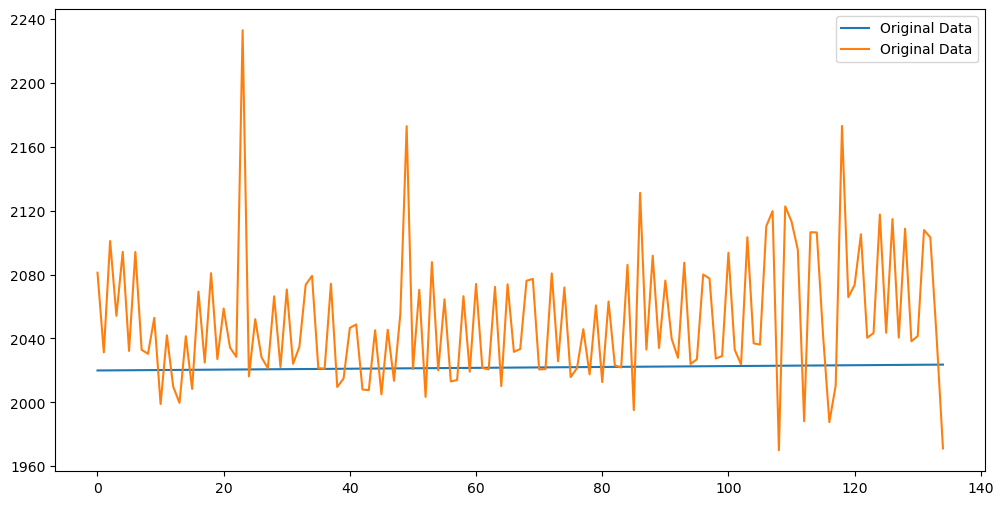

In [43]:
# Plot the data to check for trend and seasonality
plt.figure(figsize=(12, 6))
plt.plot(df_10d, label='Original Data')
plt.legend(loc='best')
plt.show()

####   The decomposition will be additive.

The image shows the amount of data over time. The trend of the data is linear, which means that the data is additive. If the trend of the data were nonlinear, then the decomposition would be multiplicative.

#### Smoothing

<Axes: xlabel='Invoice Date'>

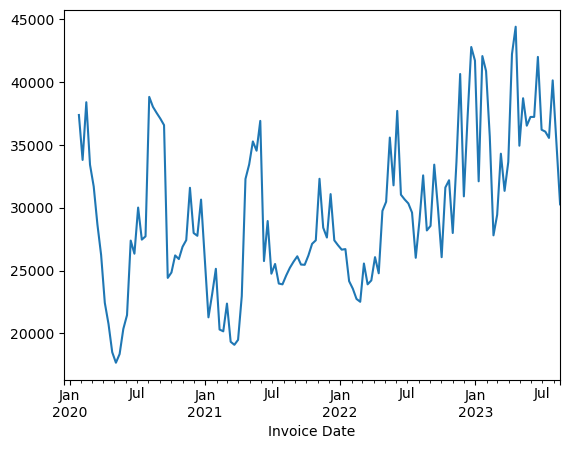

In [44]:
mean_invoice = data_10d.rolling(window = 5).mean()
mean_invoice.plot()

####  Decompositon

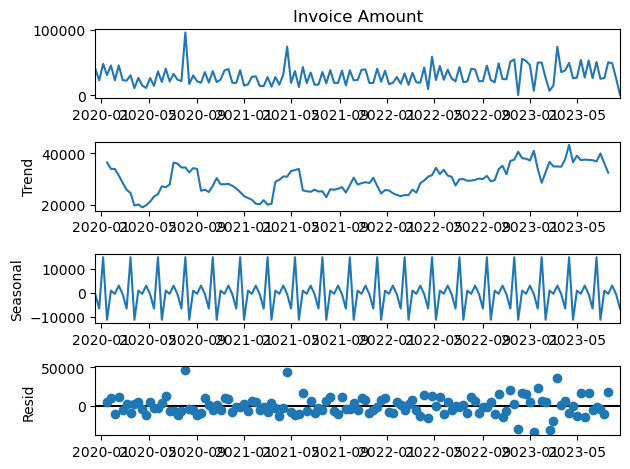

In [45]:
# Decompose the time series data
decomposition = seasonal_decompose(data_10d, model='additive')

# Plot the decomposition components (trend, seasonal, residual)
decomposition.plot()
plt.show()

####  From this graph, we can learn that the amount of data is increasing over time, and there is a monthly seasonality. We can also see that there is some random variation in the data.


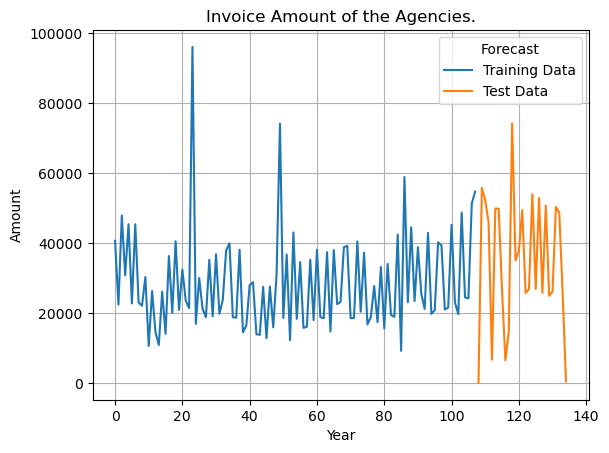

In [46]:
# Split data into train and test sets
train_size = int(len(df_10d) * 0.8)
train, test = df_10d[:train_size], df_10d[train_size:]

train['Invoice Amount'].plot()
test['Invoice Amount'].plot()
plt.grid()
plt.title('Invoice Amount of the Agencies.')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend(['Training Data','Test Data'],title='Forecast');

In [48]:


# MA (Moving Average) models
ma_5 = train.rolling(window=5).mean().iloc[-1]
ma_15 = train.rolling(window=15).mean().iloc[-1]
ma_30 = train.rolling(window=30).mean().iloc[-1]

# ARIMA model
arima_model = ARIMA(df_10d['Invoice Amount'], order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))

# SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=0)
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test))

# Extract predicted values from SARIMA forecast
sarima_forecast_values = sarima_forecast.predicted_mean


# Calculate MAE and R-squared for each model
mae_ma_5 = mean_absolute_error(test, [ma_5] * len(test))
mae_ma_15 = mean_absolute_error(test, [ma_15] * len(test))
mae_ma_30 = mean_absolute_error(test, [ma_30] * len(test))
mae_arima = mean_absolute_error(test, arima_forecast)
mae_sarima = mean_absolute_error(test, sarima_forecast_values)

r2_ma_5 = r2_score(test, [ma_5] * len(test))
r2_ma_15 = r2_score(test, [ma_15] * len(test))
r2_ma_30 = r2_score(test, [ma_30] * len(test))
r2_arima = r2_score(test, arima_forecast)
# r2_sarima = r2_score(test, sarima_forecast)

# Print MAE and R-squared for each model
print(f"MAE (MA-5): {mae_ma_5}, R-squared: {r2_ma_5}")
print(f"MAE (MA-15): {mae_ma_15}, R-squared: {r2_ma_15}")
print(f"MAE (MA-30): {mae_ma_30}, R-squared: {r2_ma_30}")
print(f"MAE (ARIMA): {mae_arima}, R-squared: {r2_arima}")
print(f"MAE (SARIMA): {mae_sarima}")

C:\Users\abhay.bhandari\AppData\Local\Temp\ipykernel_14120\3683385164.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Invoice Date'], dtype='object')
  ma_5 = train.rolling(window=5).mean().iloc[-1]
C:\Users\abhay.bhandari\AppData\Local\Temp\ipykernel_14120\3683385164.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Invoice Date'], dtype='object')
  ma_15 = train.rolling(window=15).mean().iloc[-1]
C:\Users\abhay.bhandari\AppData\Local\Temp\ipykernel_14120\3683385164.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereInvoice Date      datetime64[ns]
Invoice Amount           float64
dtype: object and None. The data was
    Invoice Date  Invoice Amount
0     2019-12-17        40605.75
1     2019-12-27        22371.40
2     2020-01-06        47846.13
3     2020-01-16        30738.75
4     2020-01-26        45360.15
..           ...             ...
103   2022-10-12        48712.20
104   2022-10-22        24445.30
105   2022-11-01        24166.10
106   2022-11-11        51242.69
107   2022-11-21        54673.10

[108 rows x 2 columns]
and
 None
before. After,
[[Timestamp('2019-12-17 00:00:00') 40605.75]
 [Timestamp('2019-12-27 00:00:00') 22371.4]
 [Timestamp('2020-01-06 00:00:00') 47846.13]
 [Timestamp('2020-01-16 00:00:00') 30738.75]
 [Timestamp('2020-01-26 00:00:00') 45360.15]
 [Timestamp('2020-02-05 00:00:00') 22713.5]
 [Timestamp('2020-02-15 00:00:00') 45346.34]
 [Timestamp('2020-02-25 00:00:00') 22966.05]
 [Timestamp('2020-03-06 00:00:00') 22057.15]
 [Timestamp('2020-03-16 00:00:00') 30272.6]
 [Timestamp('2020-03-26 00:00:00') 10564.4]
 [Timestamp('2020-04-05 00:00:00') 26276.5]
 [Timestamp('2020-04-15 00:00:00') 14541.65]
 [Timestamp('2020-04-25 00:00:00') 10834.4]
 [Timestamp('2020-05-05 00:00:00') 26077.9]
 [Timestamp('2020-05-15 00:00:00') 14024.0]
 [Timestamp('2020-05-25 00:00:00') 36266.6]
 [Timestamp('2020-06-04 00:00:00') 20055.06]
 [Timestamp('2020-06-14 00:00:00') 40496.99]
 [Timestamp('2020-06-24 00:00:00') 20851.82]
 [Timestamp('2020-07-04 00:00:00') 32395.839999999997]
 [Timestamp('2020-07-14 00:00:00') 23502.1]
 [Timestamp('2020-07-24 00:00:00') 21356.1]
 [Timestamp('2020-08-03 00:00:00') 96023.39]
 [Timestamp('2020-08-13 00:00:00') 16892.5]
 [Timestamp('2020-08-23 00:00:00') 29973.3]
 [Timestamp('2020-09-02 00:00:00') 21228.12]
 [Timestamp('2020-09-12 00:00:00') 18773.300000000003]
 [Timestamp('2020-09-22 00:00:00') 35200.31]
 [Timestamp('2020-10-02 00:00:00') 19040.33]
 [Timestamp('2020-10-12 00:00:00') 36772.8]
 [Timestamp('2020-10-22 00:00:00') 19770.7]
 [Timestamp('2020-11-01 00:00:00') 23667.7]
 [Timestamp('2020-11-11 00:00:00') 37852.7]
 [Timestamp('2020-11-21 00:00:00') 39878.350000000006]
 [Timestamp('2020-12-01 00:00:00') 18750.3]
 [Timestamp('2020-12-11 00:00:00') 18674.9]
 [Timestamp('2020-12-21 00:00:00') 38076.15]
 [Timestamp('2020-12-31 00:00:00') 14460.2]
 [Timestamp('2021-01-10 00:00:00') 16402.26]
 [Timestamp('2021-01-20 00:00:00') 27987.2]
 [Timestamp('2021-01-30 00:00:00') 28762.29]
 [Timestamp('2021-02-09 00:00:00') 13904.2]
 [Timestamp('2021-02-19 00:00:00') 13738.1]
 [Timestamp('2021-03-01 00:00:00') 27443.34]
 [Timestamp('2021-03-11 00:00:00') 12784.13]
 [Timestamp('2021-03-21 00:00:00') 27554.5]
 [Timestamp('2021-03-31 00:00:00') 15884.75]
 [Timestamp('2021-04-10 00:00:00') 31145.989999999998]
 [Timestamp('2021-04-20 00:00:00') 74090.23]
 [Timestamp('2021-04-30 00:00:00') 18570.1]
 [Timestamp('2021-05-10 00:00:00') 36702.2]
 [Timestamp('2021-05-20 00:00:00') 12191.7]
 [Timestamp('2021-05-30 00:00:00') 43013.69]
 [Timestamp('2021-06-09 00:00:00') 18290.4]
 [Timestamp('2021-06-19 00:00:00') 34510.8]
 [Timestamp('2021-06-29 00:00:00') 15730.7]
 [Timestamp('2021-07-09 00:00:00') 16063.9]
 [Timestamp('2021-07-19 00:00:00') 35225.5]
 [Timestamp('2021-07-29 00:00:00') 17968.88]
 [Timestamp('2021-08-08 00:00:00') 38033.8]
 [Timestamp('2021-08-18 00:00:00') 18803.22]
 [Timestamp('2021-08-28 00:00:00') 18499.5]
 [Timestamp('2021-09-07 00:00:00') 37364.8]
 [Timestamp('2021-09-17 00:00:00') 14671.0]
 [Timestamp('2021-09-27 00:00:00') 37941.1]
 [Timestamp('2021-10-07 00:00:00') 22505.3]
 [Timestamp('2021-10-17 00:00:00') 23149.0]
 [Timestamp('2021-10-27 00:00:00') 38759.3]
 [Timestamp('2021-11-06 00:00:00') 39175.0]
 [Timestamp('2021-11-16 00:00:00') 18481.7]
 [Timestamp('2021-11-26 00:00:00') 18569.1]
 [Timestamp('2021-12-06 00:00:00') 40440.4]
 [Timestamp('2021-12-16 00:00:00') 20353.1]
 [Timestamp('2021-12-26 00:00:00') 37222.600000000006]
 [Timestamp('2022-01-05 00:00:00') 16727.9]
 [Timestamp('2022-01-15 00:00:00') 18781.6]
 [Timestamp('2022-01-25 00:00:00') 27684.4]
 [Timestamp('2022-02-04 00:00:00') 17360.6]
 [Timestamp('2022-02-14 00:00:00') 33128.8]
 [Timestamp('2022-02-24 00:00:00') 15598.7]
 [Timestamp('2022-03-06 00:00:00') 34015.2]
 [Timestamp('2022-03-16 00:00:00') 19401.3]
 [Timestamp('2022-03-26 00:00:00') 18916.3]
 [Timestamp('2022-04-05 00:00:00') 42401.4]
 [Timestamp('2022-04-15 00:00:00') 9170.7]
 [Timestamp('2022-04-25 00:00:00') 58851.200000000004]
 [Timestamp('2022-05-05 00:00:00') 23027.3]
 [Timestamp('2022-05-15 00:00:00') 44482.6]
 [Timestamp('2022-05-25 00:00:00') 23380.6]
 [Timestamp('2022-06-04 00:00:00') 38800.399999999994]
 [Timestamp('2022-06-14 00:00:00') 25496.91]
 [Timestamp('2022-06-24 00:00:00') 21142.98]
 [Timestamp('2022-07-04 00:00:00') 42893.6]
 [Timestamp('2022-07-14 00:00:00') 19732.4]
 [Timestamp('2022-07-24 00:00:00') 20798.3]
 [Timestamp('2022-08-03 00:00:00') 40191.68]
 [Timestamp('2022-08-13 00:00:00') 39267.9]
 [Timestamp('2022-08-23 00:00:00') 20967.52]
 [Timestamp('2022-09-02 00:00:00') 21552.4]
 [Timestamp('2022-09-12 00:00:00') 45172.1]
 [Timestamp('2022-09-22 00:00:00') 22975.1]
 [Timestamp('2022-10-02 00:00:00') 19640.9]
 [Timestamp('2022-10-12 00:00:00') 48712.2]
 [Timestamp('2022-10-22 00:00:00') 24445.300000000003]
 [Timestamp('2022-11-01 00:00:00') 24166.1]
 [Timestamp('2022-11-11 00:00:00') 51242.69]
 [Timestamp('2022-11-21 00:00:00') 54673.100000000006]]
None.